## 비지도 학습

비지도 학습 문제에는 클러스터링, 차원 압축, 이상감즈 등이 있지만 이번 챕터에선 클러스터링에 대해 다룬다.

## 9.1 2차원 입력데이터


이전 6장에서 사용한 데이터를 사용하지만 클래스(라벨) 데이터는 사용하지 않는다.

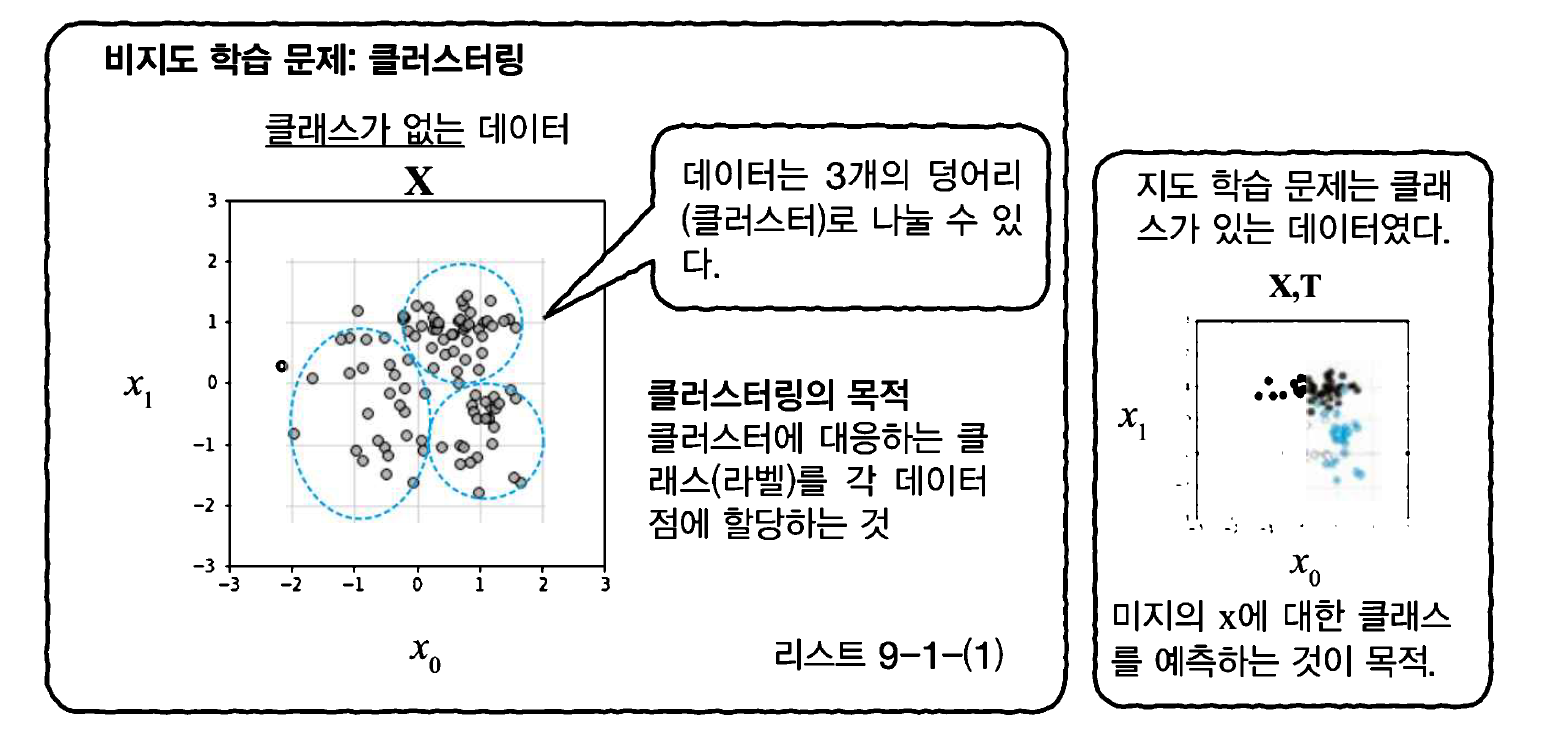

클러스터링은 위와 같이 같은 특성을 가지는 객체들을 묶어 분류하는 것이며, 지도 학습과 다르게 라벨을 사용하지않고 학습을 시킨다.


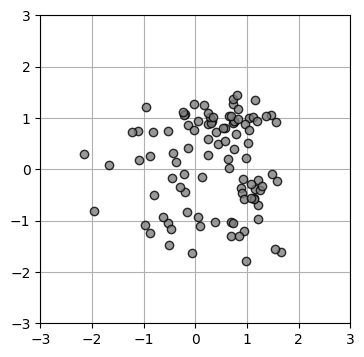

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 데이터 생성
np.random.seed(1)
N = 100
K = 3
T3 = np.zeros((N,3), dtype=np.uint8)
X = np.zeros((N,2))
X_range0 = [-3, 3]
X_range1 = [-3, 3]
X_col = ['cornflowerblue', 'black', 'white']
Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]])
Sig = np.array([[.7,.7],[.8, .3],[.3, .8]])
Pi = np.array([0.4, 0.8, 1])

for n in range(N):
  wk = np.random.rand()
  for k in range(K):
    if wk < Pi[k]:
      T3[n,k] = 1
      break
  for k in range(2):
    X[n,k] = (np.random.randn() * Sig[T3[n,:] ==1, k] + Mu[T3[n, :] == 1, k] )

# 데이터 그리기

def show_data(x):
  plt.plot(x[:,0], x[:,1], linestyle='none', marker='o', markersize=6, markeredgecolor='black', color = 'gray', alpha=0.8)
  plt.grid(True)

# 메인
plt.figure(1, figsize=(4,4))
show_data(X)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()
np.savez('data_ch9.npz', X = X, X_range0 = X_range0, X_range1 = X_range1)


## 9.2 K-means 기법

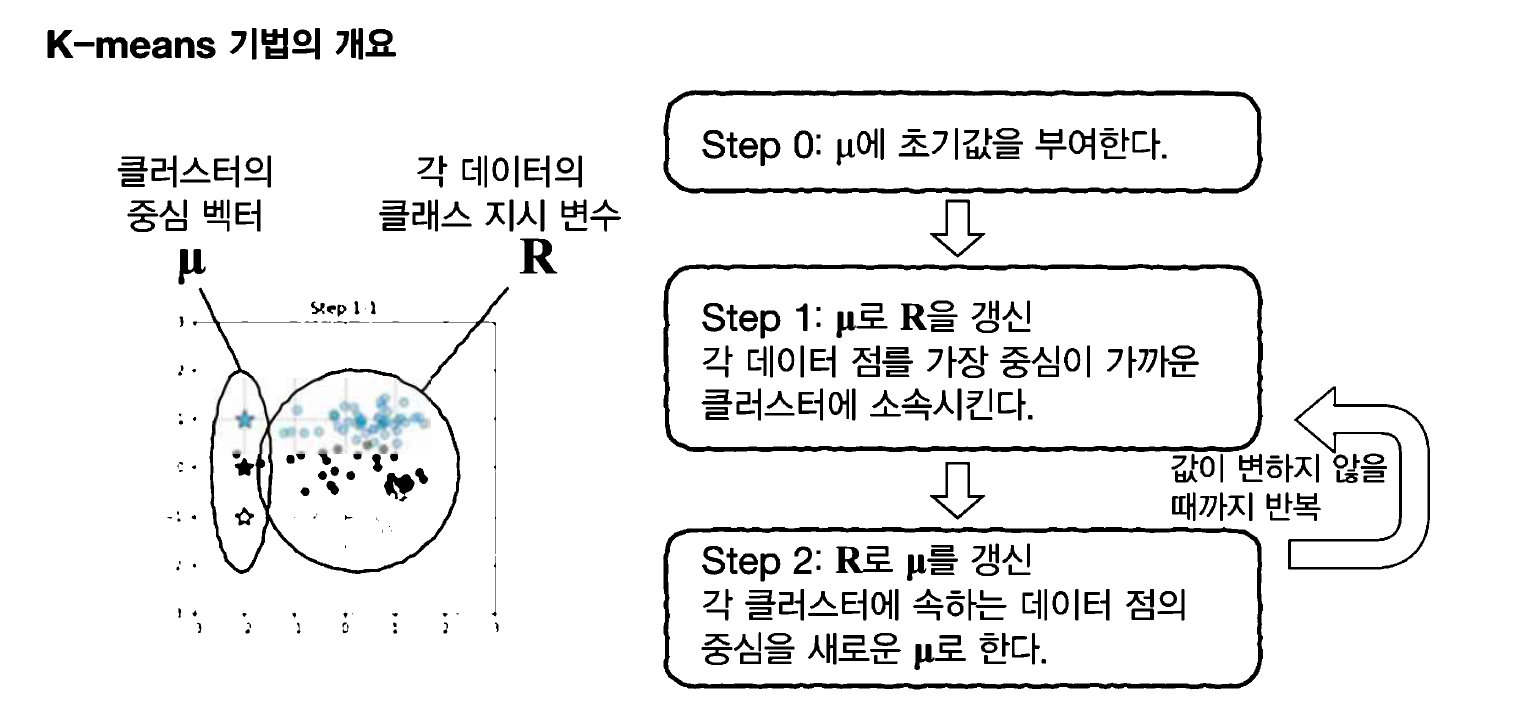

위의 방법대로 μ(클러스터의 중벡터)와 R(각 데이터의 클래스 지시 변수)를 매개변수로 가진다.

첫번째로 μ에 초기값을 부여한 후에 계속 갱신을 통해 μ 와 R를 업데이트 한다.

또한 K라는 매개 변수를 가지며, 이는 분할할 클러스터의 수이다.

9.2.2 step 0: 변수의 준비와 초기화

k 번째 클러스터 중심 벡터는 아래와 같이 나타낸다.

$$ μ_k = [μ_{k0},μ_{k1}] (k = 0, 1, 2)$$

입력 차원은 2차원이기때문에 클러스터 중심도 2차원 벡터가 되고 있다.

K = 3이기 때문에 중심벡터를 u_0 = [-2, 1], u_1 = [-2, 0], u_2 = [-2, 1]으로 정한다.


또한 클래스 지시 변수 R은 각 데이터가 어느 클래스에 속해있는지 나타낸 행렬이다.

데이터 n에 대한 클래스 지시 변수를 벡터로 나타내면, 클래스 0에 속하는 경우는 다음과 같다.

$$ r_n = [r_{n0},r_{n1},r_{n2}] = [1,0,0]$$

여기서 유의해야할 점이 각 데이터의 분포가 기본적으로 class마다 이루어져있다라는 가정하에 들어가야한다.

만약 class마다 분포가 너무 상이하면 학습이 제대로 이뤄지않을 가능성이 있다.

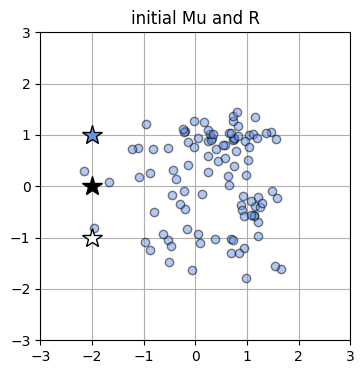

In [ ]:
# Mu, R초기화

Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
R = np.c_[np.ones((N,1), dtype=int), np.zeros((N,2), dtype=int)]

# 데이터를 그리는 함수

def show_prm(x, r, mu, col):
  for k in range(K):
    plt.plot(x[r[:,k] == 1, 0],x[r[:,k] == 1, 1], marker='o', markerfacecolor=X_col[k], markeredgecolor='k', markersize=6, alpha=0.5, linestyle='none' )
    plt.plot(mu[k,0], mu[k,1], marker='*', markerfacecolor=X_col[k],markersize=15, markeredgecolor='k',markeredgewidth=1)
  plt.xlim(X_range0)
  plt.ylim(X_range1)
  plt.grid(True)

plt.figure(figsize=(4,4))
R = np.c_[np.ones((N,1)), np.zeros((N,2))]
show_prm(X, R, Mu, X_col)
plt.title('initial Mu and R')
plt.show()

9.2.3 Step 1:R의 갱신

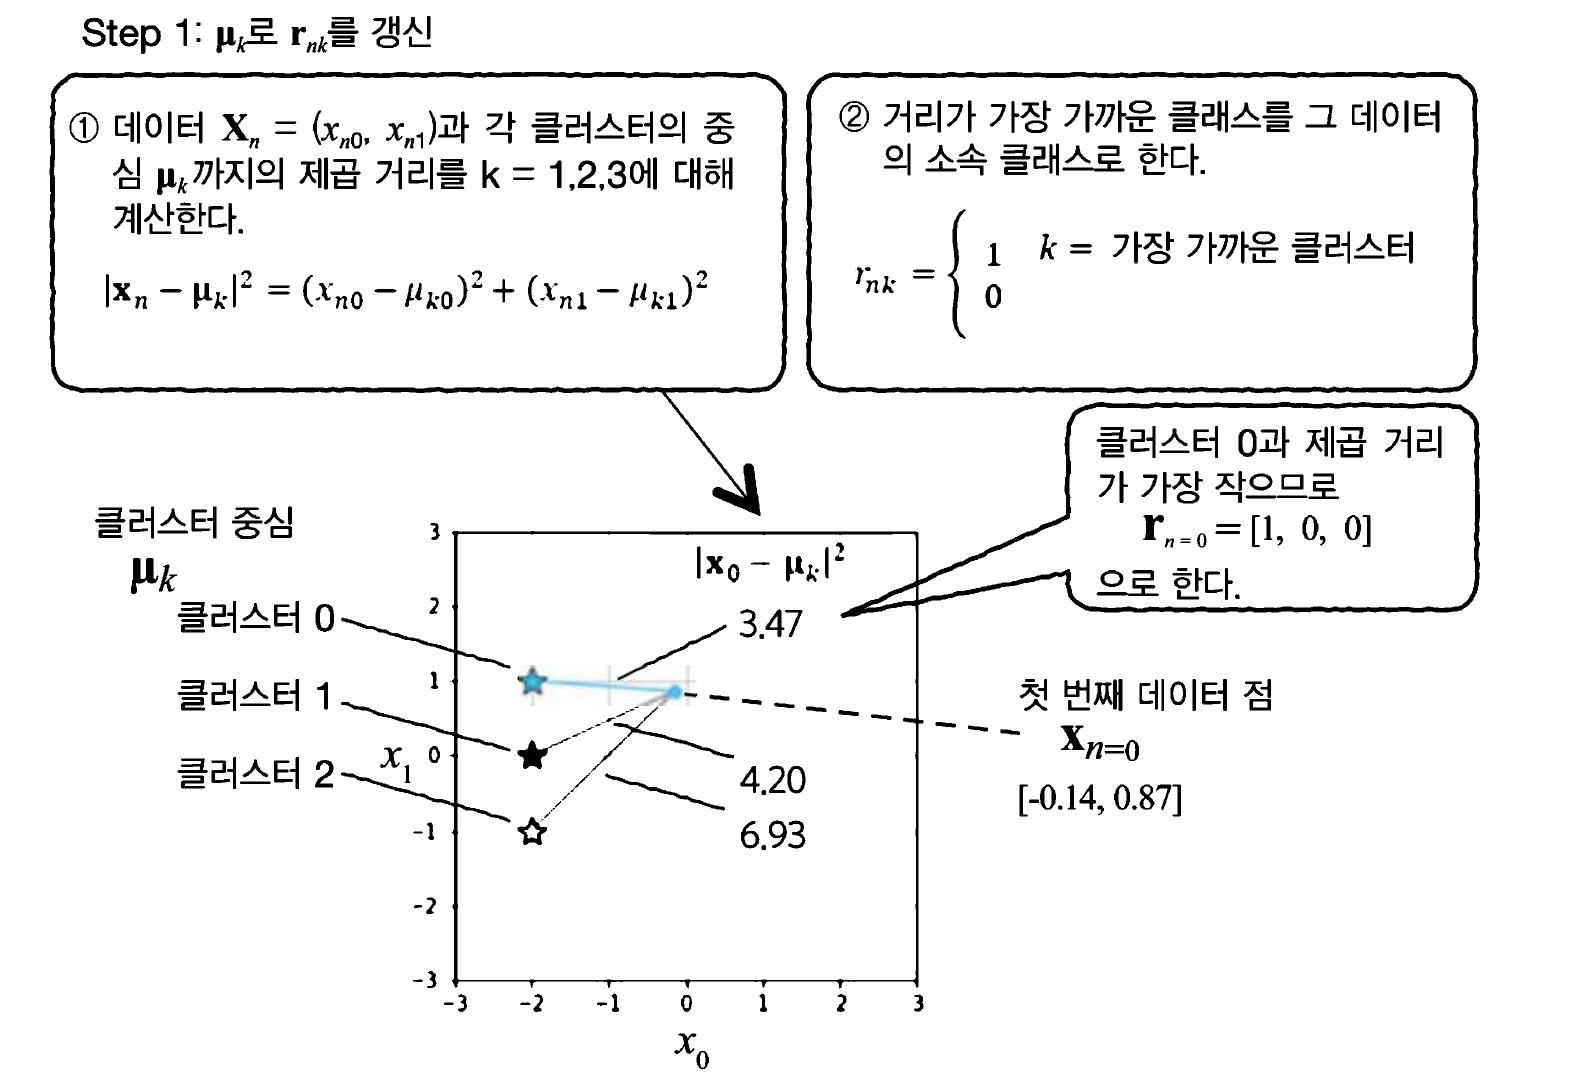

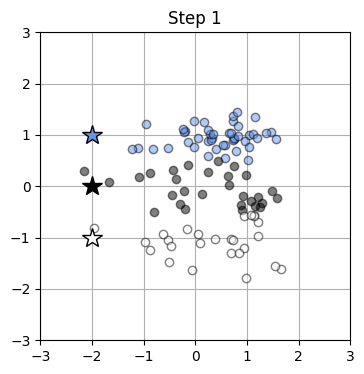

In [ ]:
from os import kill
# r을 정한다.

def step1_kmeans(x0, x1, mu):
  N = len(x0)
  r = np.zeros((N,K))
  for n in range(N):
    wk = np.zeros(K)
    for k in range(K):
      wk[k] = (x0[n] - mu[k,0])**2 + (x1[n] - mu[k,1]) ** 2
    r[n, np.argmin(wk)] =1
  return r

plt.figure(figsize=(4,4))
R = step1_kmeans(X[:,0], X[:,1], Mu)
show_prm(X, R, Mu, X_col)
plt.title('Step 1')
plt.show()

9.2.4 Step 2: μ의 갱신

갱신 방법은 "각 클러스터에 속하는 데이터 점의 중심을 새로운 μ로 한다."

k = 0에 속하는 데이터, r_n = [1,0,0]의 라벨을 가진 데이터 점에 주목해 각 평균을 구한다.

$$ μ_{k=0,0} = \frac{1}{N_k}\sum_{n in cluster 0}x_{n0}, μ_{k=0,1} = \frac{1}{N_k}\sum_{n in cluster 0}x_{n1}  $$

합의 기호 아래를 n in cluster 0으로 하여, 클러스터 0에 속하는 데이터 n의 합을 취하는 의미이다.

동일한 절차를 k=1, k=2에 대해 실시하면 이 과정은 완료이다.

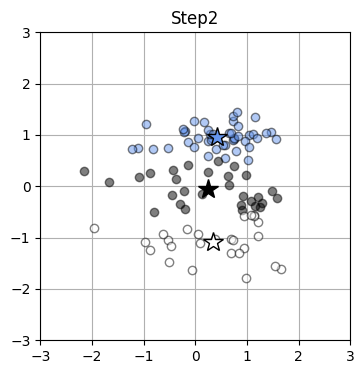

In [ ]:
# Mu 결정

def step2_kmeans(x0, x1, r):
  mu = np.zeros((K,2))
  for k in range(K):
    mu[k, 0] = np.sum(r[:, k] * x0) /np.sum(r[:, k])
    mu[k, 1] = np.sum(r[:, k] * x1) /np.sum(r[:, k])
  return mu

plt.figure(figsize=(4,4))
Mu = step2_kmeans(X[:, 0], X[:, 1], R)
show_prm(X, R, Mu, X_col)
plt.title('Step2')
plt.show()

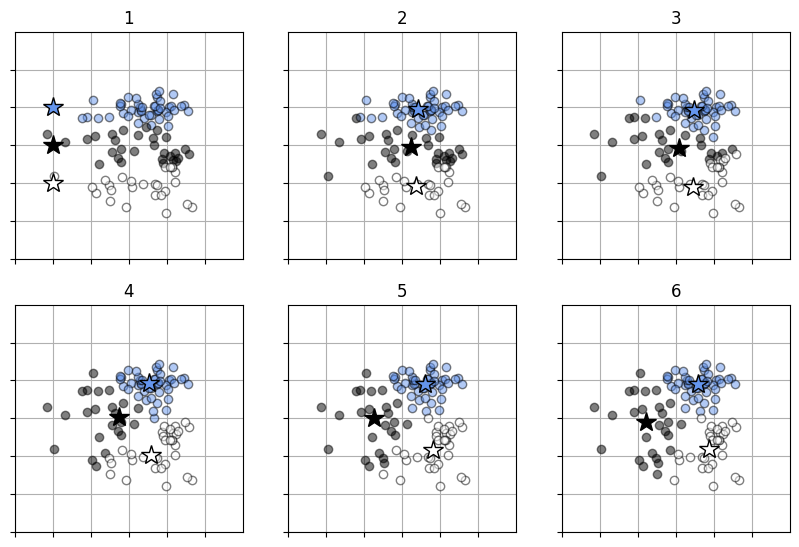

In [ ]:
# step1과 step2의 절차를 반복함.

plt.figure(1, figsize=(10, 6.5))
Mu = np.array([[-2,1],[-2,0],[-2, -1]])
max_it = 6
for it in range(0, max_it):
  plt.subplot(2, 3, it+1)
  R = step1_kmeans(X[:, 0], X[:, 1], Mu)
  show_prm(X, R, Mu, X_col)
  plt.title("{0:d}".format(it+1))
  plt.xticks(range(X_range0[0], X_range0[1]), "")
  plt.yticks(range(X_range1[0], X_range1[1]), "")
  Mu = step2_kmeans(X[:, 0], X[:,1], R)
plt.show()

위의 그래프로 보면 점점 클러스터의 중심으로 이동하는 것으로 볼 수 있다.

또한 어느정도 수렴을하면 더이상 반복하도 R과 u는 변하지 않는다.

9.2.5 왜곡 척도

학습이 진행됨에 따라 감소하는 목적 함수가 있을까?

K-means의 경우 데이터 점이 속하 ㄴ클러스터의 중심까지 제곱 거리를 전체 데이터로 합한 것이 목적함수에 대응한다.

$$J = \sum_{k=0}^{2}\sum_{n in cluster k}|x_n - μ_k|^2$$

r_nk는 데이터 n이 속한 클러스터에서만 1, 속하지 않는 클러스터에서는 0이 되는 변수라는 사실을 통해 아래와 같이 나타낼 수 있다.

$$ J = \sum_{n=0}^{N-1}\sum_{k=0}^{K-1}r_{nk}|x_n - μ_k|^2  $$

In [ ]:
# 목적 함수

def distortion_measure(x0, x1, r, mu):
  N = len(x0)
  J = 0
  for n in range(N):
    for k in range(K):
      J = J + r[n,k] * ((x0[n] - mu[k,0])**2 + (x1[n] - mu[k,1])**2)
  return J

# test
# Mu와 R의 초기화

Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
R = np.c_[np.ones((N,1), dtype=int), np.zeros((N,2), dtype=int)]
distortion_measure(X[:, 0], X[:, 1], R, Mu)

771.7091170334878

[627.54  73.39  70.39  57.59  48.31  47.28  46.86  46.86  46.86  46.86]


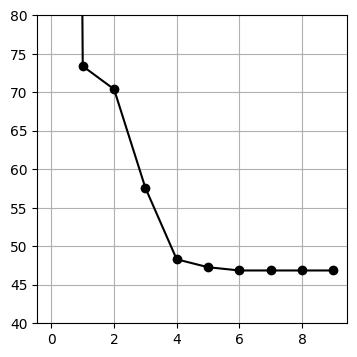

In [ ]:
# Mu와 R의 초기화

N = X.shape[0]
K = 3
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
R = np.c_[np.ones((N,1), dtype=int), np.zeros((N,2), dtype=int)]
max_it = 10
it = 10
DM = np.zeros(max_it)
for it in range(0, max_it):
  R = step1_kmeans(X[:, 0], X[:, 1], Mu)
  DM[it] = distortion_measure(X[:, 0], X[:, 1], R, Mu)
  Mu = step2_kmeans(X[:,0], X[:, 1], R)

print(np.round(DM, 2))
plt.figure(2, figsize=(4,4))
plt.plot(DM, color='black', linestyle='-', marker='o')
plt.ylim(40, 80)
plt.grid(True)
plt.show()

## 9.3 가우시안 혼합 모델


9.3.1 확률적 클러스터링

K-means 기법은 데이터 점을 반드시 클러스터에 할당한다.

ex) 클러스터 0의 중심에 있는 데이터 점 A도, 클러스터 0의 끝에 있는 데이터 점 B에도 동일한 r = [1,0,0]이 할당된다.


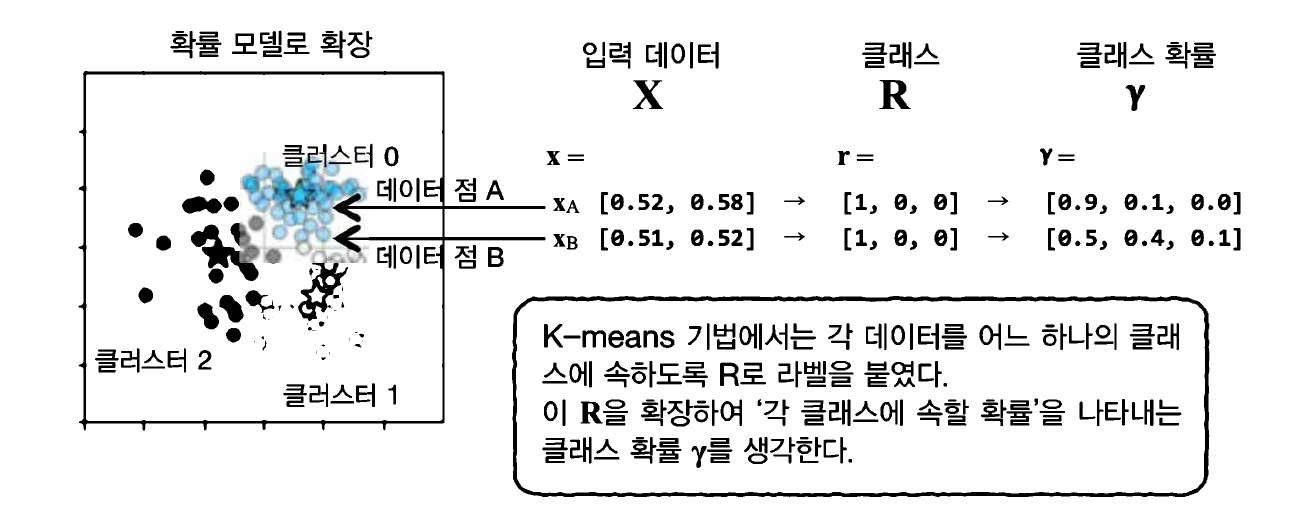

데이터 점 A가 클러스터 0에 속할 확률은 0.9이며, 클러스터 1과 2에 속할 확률은 각각 0.1와 0.0이라고 생각한다.
이것을 감마를 사용하여 아래의 식처럼 나타낸다.

$$ γ_A = [γ_{A0}γ_{A1}γ_{A2}] = [0.9, 0.1, 0.0]$$

어떤 쪽이든 클러스터에 반드시 속함으로 3개의 확률을 더하면 1이 된다.

k-means 기법으로 다룬 R의 확장이다.

데이터 점 B에 대해서는 아래와 같다

$$ γ_A = [γ_{B0}γ_{B1}γ_{B2}] = [0.5, 0.4, 0.1]$$

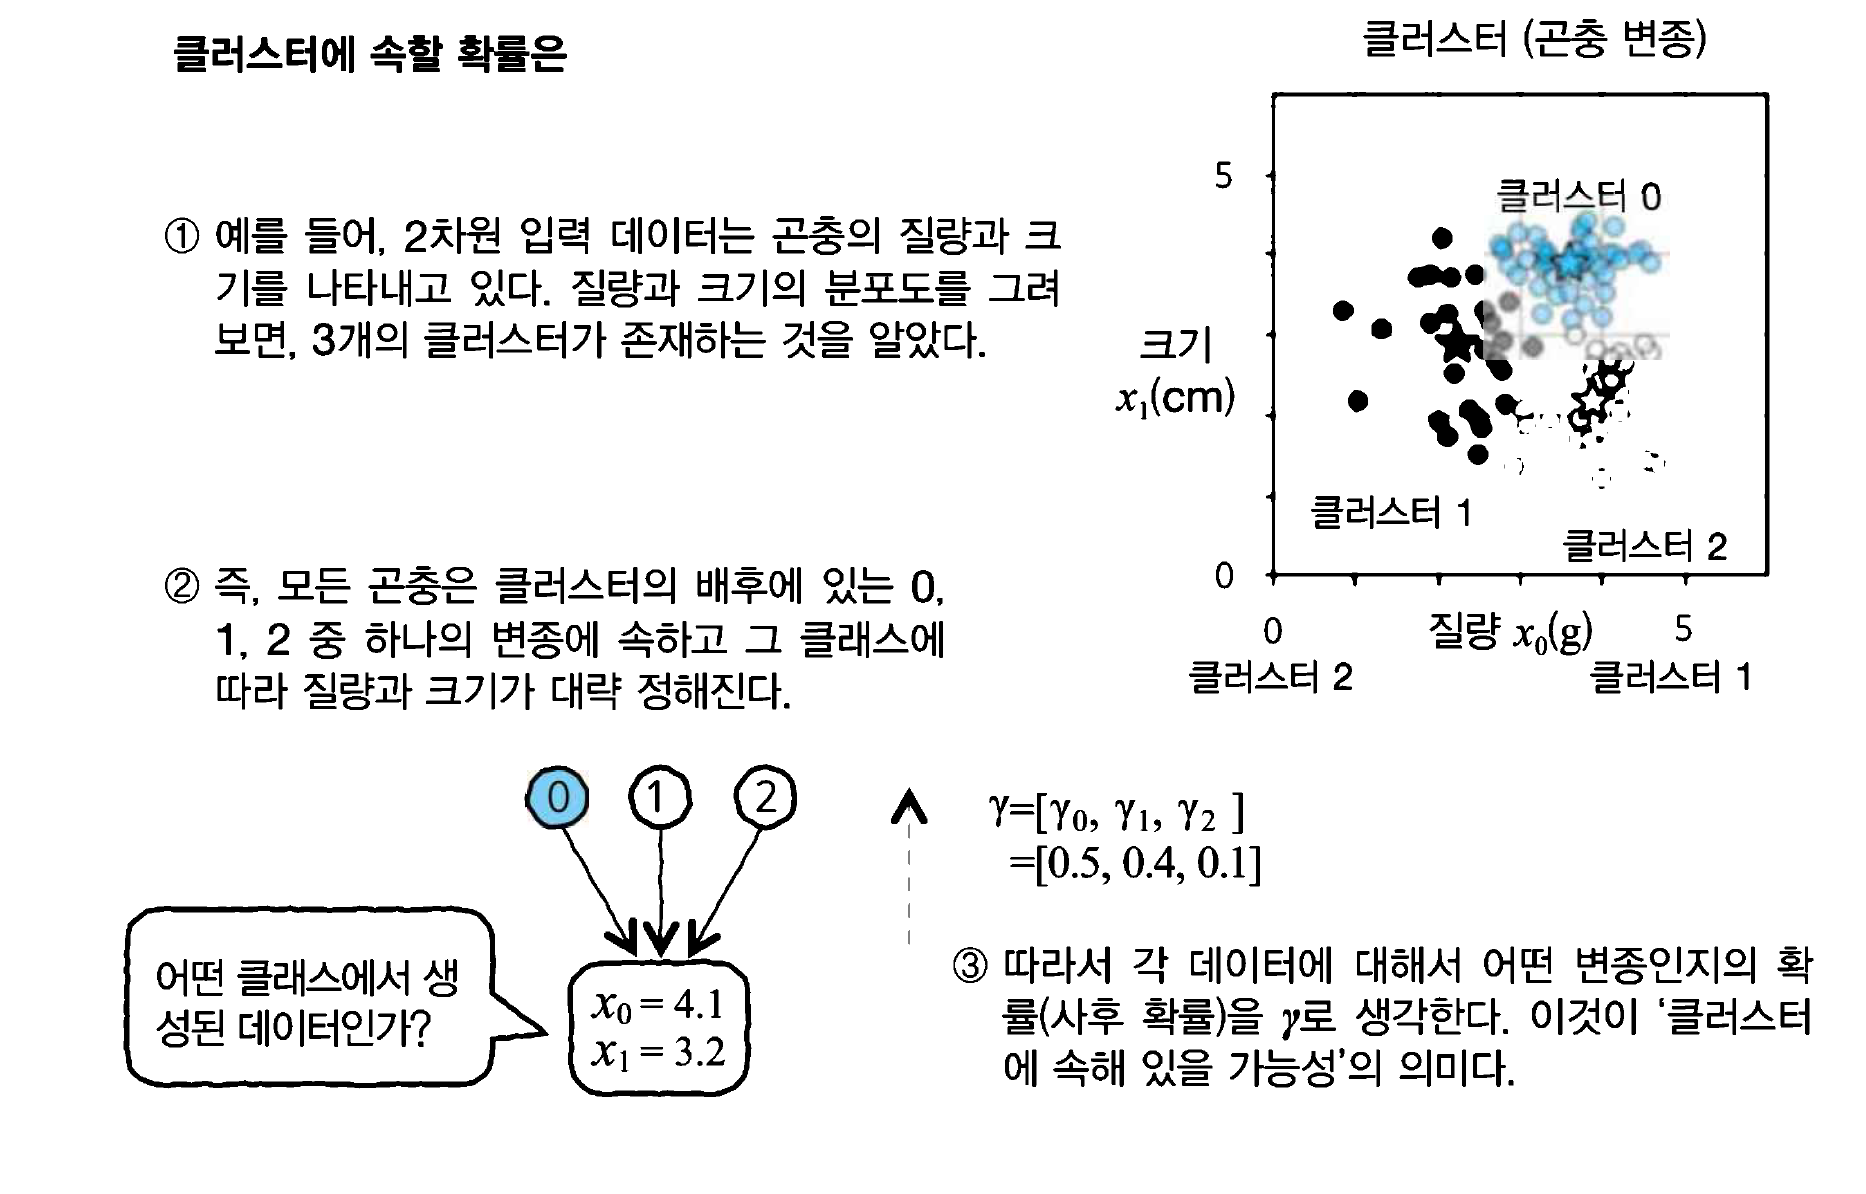

위에서 모든 곤충은 어떤 쪽의 변종에 속해 있으며, 이에 따라 질량과 크기가 정해진다고 볼수 있다.

그렇기에 3개의 클러스터 뒤에 3개의 클래스의 존재가 암시된것이며, 데이터에 영향을 준 변수를 잠재 변수 또는 숨은 변수라고 한다.

$$ z_n = [z_{n0},z_{n1},z_{n2}] $$

잠재 변수라는 것을 Z로 나타냈을 때, 데이터 n이 클러스터 k에 속할 확률 γnk이란 데이터 xn인 곤충이 '클래스 k의 변종일 확률'을 의미한다. 이를 수식으로 나타내면 아래와 같다.

$$ γ_{nk} = P(z_{nk} = 1|x_n) $$

9.3.2 가우시안 혼합 모델

부담율 r를 구하기 위해 가우시안 혼합 모델을 사용한다.

가우시안 혼합 모델은 4.7.9절에서 설명한 2차원 가우스 함수 여러개를 합친것이다.

$$ p(x) = \sum^{K-1}_{k=0}π_kN(x|μ_k, ∑_k)  $$

여기서 N(x|μ_k, ∑_k)는 평균 u_k, 공분한 행렬 ∑_k의 2차원 가우스 함수를 나타낸다.

위의 식은 서로 다른 평균과 공분산 행렬을 가진 2차원 가우스 함수가 K개 겹친 분포를 나타낸다.



In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
# 가우시안 혼합 모델을 나타내는 함수

# 데이터 불러오기
import numpy as np
wk = np.load('data_ch9.npz')
X = wk['X']
X_range0 = wk['X_range0']
X_range1 = wk['X_range1']

# 가우스 함수

def gauss(x, mu, sigma):
  N, D = x.shape
  c1 = 1 / (2* np.pi) ** (D/ 2)
  c2 = 1 / (np.linalg.det(sigma) ** (1/2))
  inv_sigma = np.linalg.inv(sigma)
  c3 = x - mu
  c4 = np.dot(c3, inv_sigma)
  c5 = np.zeros(N)
  for d in range(D):
    c5 = c5 + c4[:,d] * c3[:,d]
  p = c1 * c2 * np.exp(-c5/2)
  return p

x = np.array([[1,2], [2,1], [3,4]])
mu = np.array([1,2])
sigma = np.array([[1,0], [0,1]])
print(gauss(x, mu, sigma))


[0.15915494 0.05854983 0.00291502]


In [ ]:
# 가우시안 함수를 여러번 더해서 가우시안 혼합 모델을 정의한다.

def mixgauss(x, pi, mu, sigma):
    N, D = x.shape
    K = len(pi)
    p = np.zeros(N)
    for k in range(K):
        p = p + pi[k] * gauss(x, mu[k, :], sigma[k, :, :])
    return p

# Example usage
x = np.array([[1, 2], [2, 2], [3, 4]])
pi = np.array([0.3, 0.7])
mu = np.array([[1, 1], [2, 2]])
sigma = np.array([[[1, 0], [0, 1]], [[2.0, 0], [0, 1]]])

print(mixgauss(x, pi, mu, sigma))

[0.09031182 0.09634263 0.00837489]


In [ ]:
# 등고선 표시 함수와 3D로 나타내는 함수

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# 혼합 가우스 등고선 표시

def show_contour_mixgauss(pi, mu, sigma):
  xn = 40
  x0 = np.linspace(X_range0[0], X_range0[1], xn)
  x1 = np.linspace(X_range1[0], X_range1[1], xn)
  xx0, xx1 = np.meshgrid(x0, x1)
  x = np.c_[np.reshape(xx0, (xn * xn, 1)), np.reshape(xx1, (xn * xn, 1))]
  f = mixgauss(x, pi, mu, sigma)
  f = f.reshape(xn, xn)
  f = f.T
  plt.contour(x0, x1, f, 10, colors='gray')

# 혼합 가우스 3D 표시

def show3d_mixgauss(ax, pi, mu, sigma):
  xn = 40
  x0 = np.linspace(X_range0[0], X_range0[1], xn)
  x1 = np.linspace(X_range1[0], X_range1[1], xn)
  xx0, xx1 = np.meshgrid(x0, x1)
  x = np.c_[np.reshape(xx0,( xn * xn, 1)), np.reshape(xx1, (xn* xn, 1))]
  f = mixgauss(x, pi, mu, sigma)
  f = f.reshape(xn,xn)
  f = f.T
  ax.plot_surface(xx0, xx1, f, rstride=2, cstride=2, alpha=0.3, color='blue', edgecolor='black')

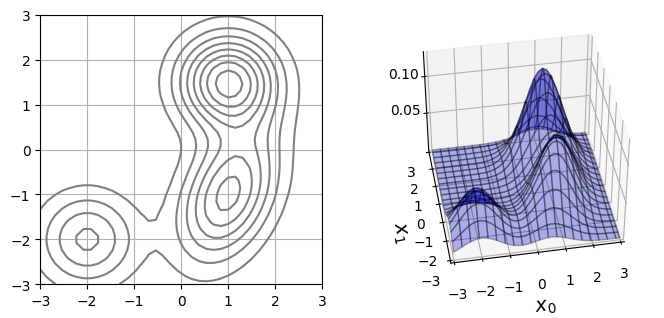

In [ ]:
# test

pi = np.array([0.2, 0.4, 0.4])
mu = np.array([[-2, -2], [-1, 1],[1.5 , 1]])
sigma = np.array([[[.5, 0],[0, .5]], [[1, 0.25], [0.25, .5]],[[.5, 0], [0, .5]]])

Fig = plt.figure(1, figsize=(8, 3.5))
Fig.add_subplot(1, 2, 1)
show_contour_mixgauss(pi, mu, sigma)
plt.grid(True)

Ax = Fig.add_subplot(1,2,2, projection='3d')
show3d_mixgauss(Ax, pi, mu, sigma)
Ax.set_zticks([0.05, 0.10])
Ax.set_xlabel('$x_0$', fontsize=14)
Ax.set_ylabel('$x_1$', fontsize=14)
Ax.view_init(40, -100)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()

9.3.3 EM 알고리즘의 개요

EM 알고리즘 : 알고리즘 기댓값 최대화 알고리즘은 관측되지 않는 잠재변수에 의존하는 확률모델에서 최대가능도나 최대사후확률을 갖는 모수의 추정값을 찾는 반복적인 알고리즘이다.

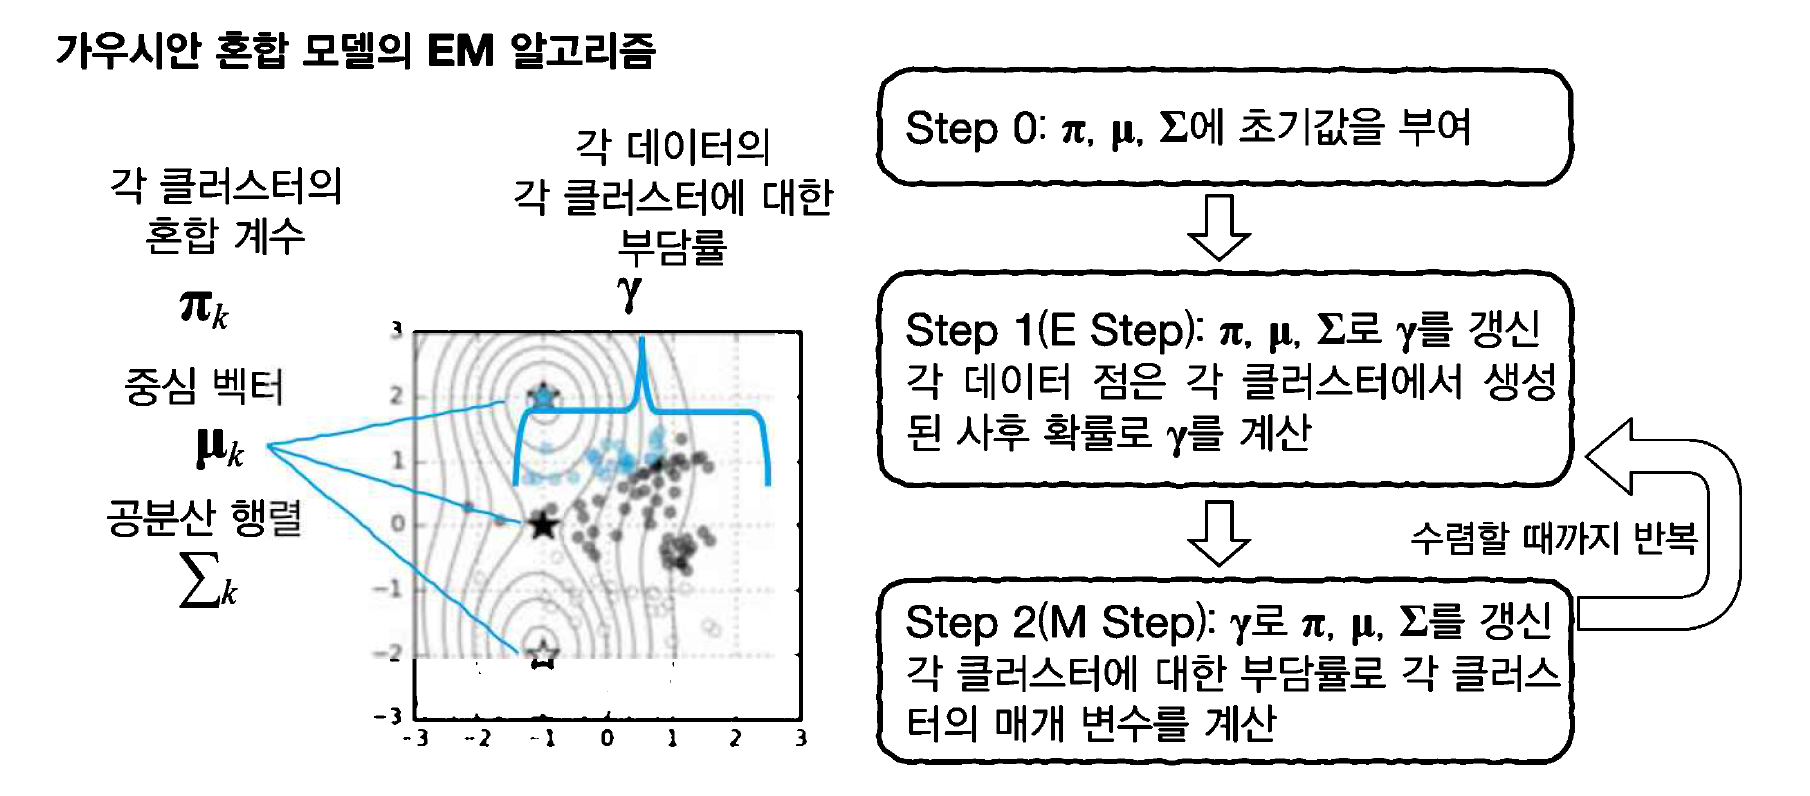

K-means 기법에서는 각 클러스터를 중심벡터 u로 특정했지만, 가우신안 혼합 모델은 공분산 행렬에 의해 각 클러스터의 확산 정도를 기술한다.

알고리즘 step 0 에서는 pi, mu, sum 초기화로 시작하여,

step1에서는 현시점의 pi, mu, sum를 사용하여 r을 구한다.

이 step은 EM 알고리즘으로 E Step이라고 한다.

다음 Step2에서는 현시점 r를 사용하여 pi, mu, sum를 구한다.

이 step은 EM 알고리즘 M Step이라고 불린다. 이 E step과 M step을 매개 변수가 수렴할 때까지 반복한다.

9.3.4 Step 0: 변수의 준비 및 초기화

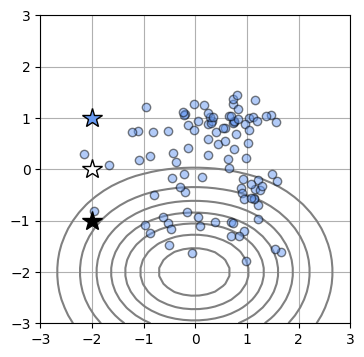

In [ ]:
# 초기 설정

N = X.shape[0]
K = 3
Pi = np.array([0.33, 0.33, 0.34])
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
Sigma = np.array([[[1,0], [0,1]], [[1,0], [0,1]], [[1,0], [0, 1]]])
Gamma = np.c_[np.ones((N,1)), np.zeros((N,2))]

X_col = np.array([[0.4, 0.6, 0.95], [1, 1, 1], [0, 0, 0]])

# 데이터 그리기

def show_mixgauss_prm(x, gamma, pi, mu, sigma):
  N, D = x.shape
  show_contour_mixgauss(pi, mu, sigma)
  for n in range(N):
    col = gamma[n,0] * X_col[0] + gamma[n,1] * X_col[1] + gamma[n,2] * X_col[2]
    plt.plot(x[n, 0], x[n, 1], 'o' , color = tuple(col), markeredgecolor='black', markersize=6, alpha=0.5)

  for k in range(K):
    plt.plot(mu[k, 0], mu[k, 1], marker='*', markerfacecolor=tuple(X_col[k]), markersize= 15, markeredgecolor='k', markeredgewidth=1)

  plt.grid(True)

plt.figure(1, figsize=(4,4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

9.3.5 Step 1(E step): r 갱신

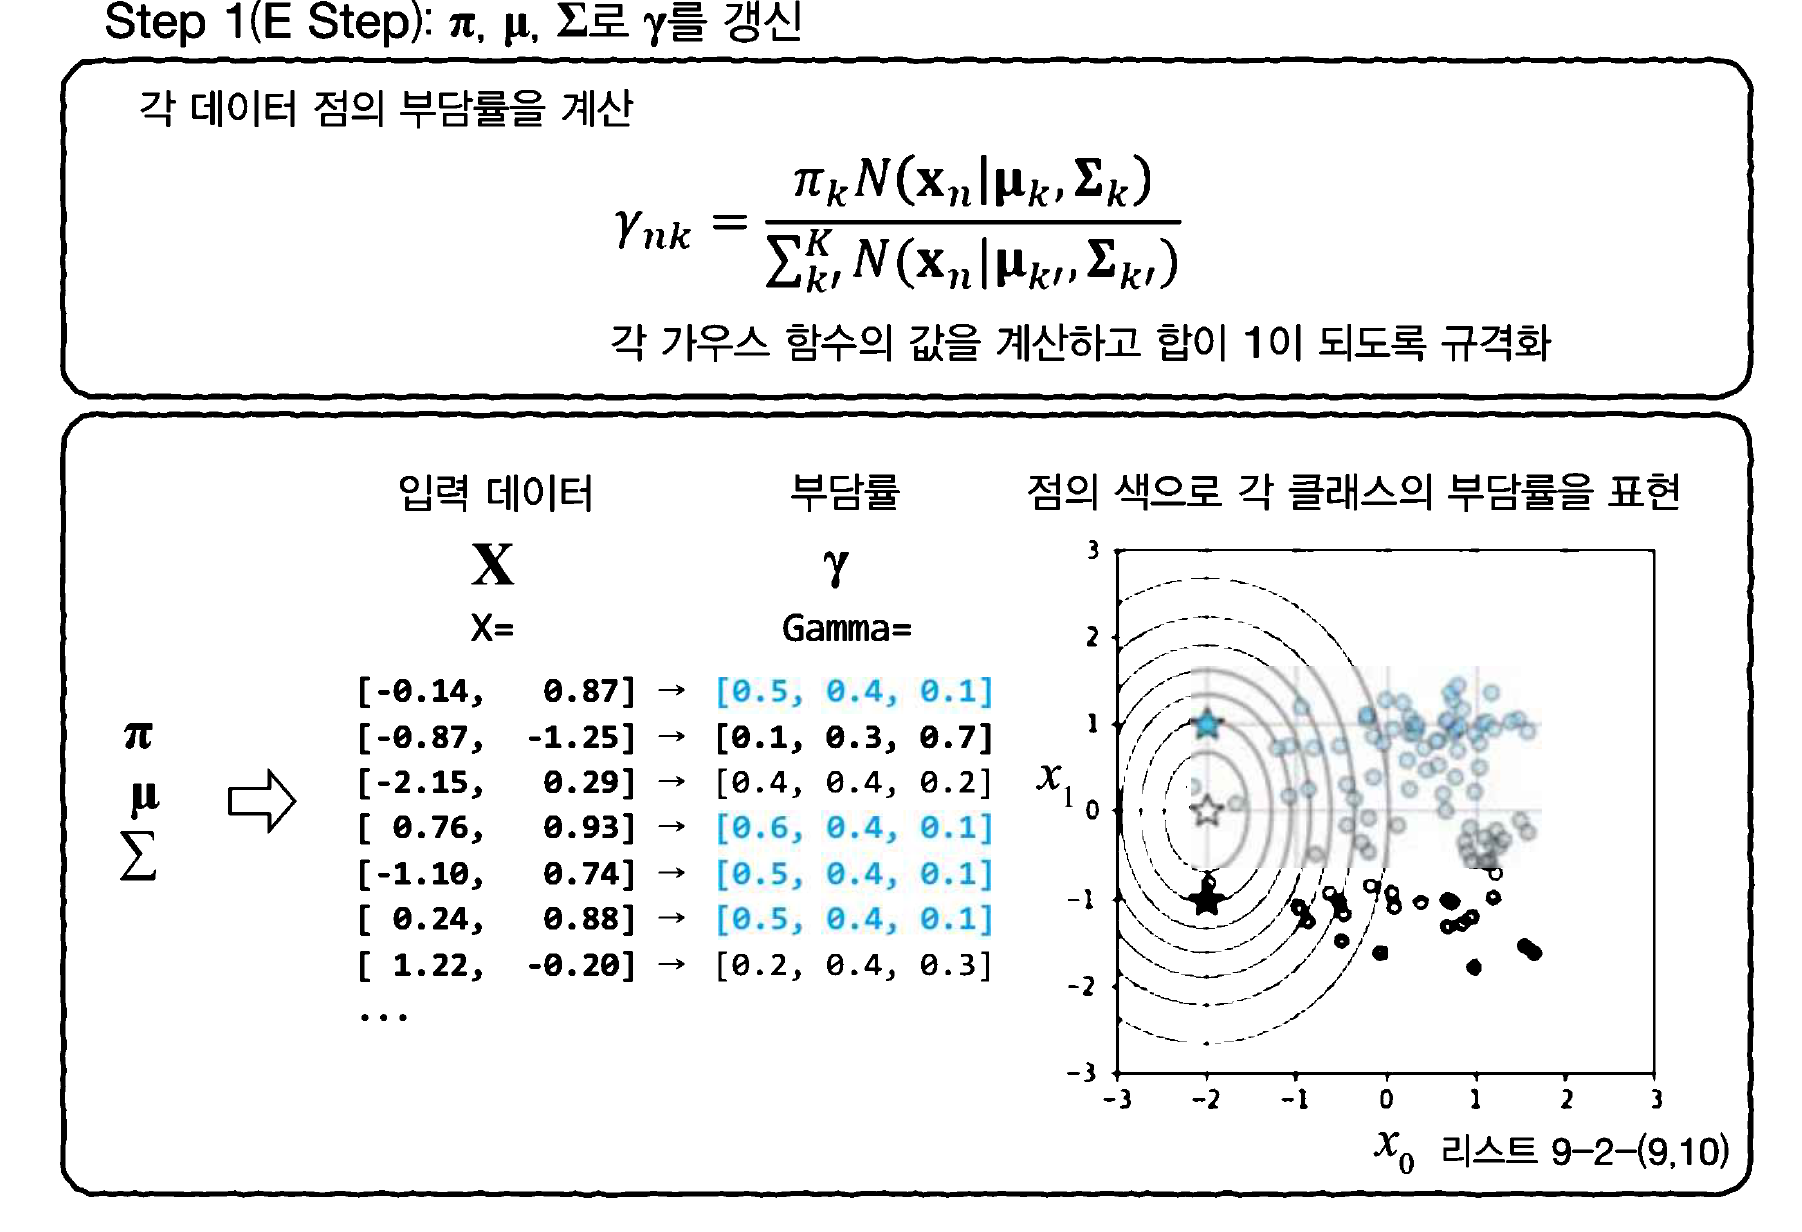

어떤 데이터 점 n에 착안했을 때, 그 데이터 점에서 각 가우스 함수의 높이를 구하고 K에서 합을 취해 1이 되도록 a의 총합으로 나누어 규ㅠ격화 한것을 r_nk로 한다.

가우스 함수의 값이 높을수록 부담률도 높아진다는 직관적인 갱신 방법이라고 할 수 있다.

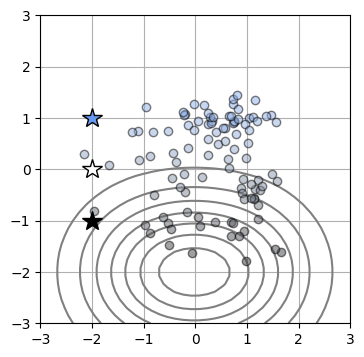

In [ ]:
# gamma를 갱신(E step)

def e_step_mixgauss(x, pi, mu, sigma):
  N, D = x.shape
  K = len(pi)
  y = np.zeros((N, K))
  for k in range(K):
    y[:, k] = gauss(x, mu[k, :], sigma[k, :, :])
  gamma = np.zeros((N,K))
  for n in range(N):
    wk = np.zeros(K)
    for k in range(K):
      wk[k] = pi[k] * y[n, k]
    gamma[n, :] = wk / np.sum(wk)
  return gamma

Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)

# 결과 표시
plt.figure(1, figsize=(4,4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

9.3.6 step(M step):pi mu sum의 갱신

1. 각 클러스터에 대한 부담률의 합 N을 구한다.

$$N_k = \sum_{n=0}^{N-1}γ_{nk} $$

2. 혼합률 pi를 갱신

$$ π_k^{new} = \frac{N_k}N $$

3. 중심 벡터 갱신

$$ u_k^{new} = \frac{1}{N_k}\sum_{n=0}^{N-1}γ_{nk}x_n $$

4. 가우스의 공분산 행렬을 갱신

$$ \sum_k^{new} = \frac{1}{N_k}\sum^{N-1}_{n = 0}γ_{nk}(x_n - μ_k^{new})^T(x_n - μ_k^{new})  $$

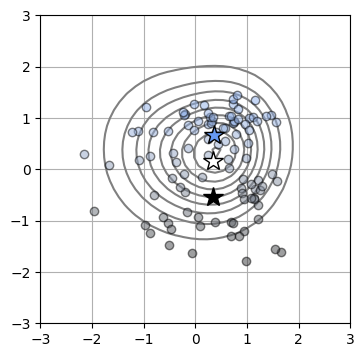

In [ ]:
# Pi, Mu, Sigma 갱신(M step)

def m_step_mixgauss(x, gamma):
  N, D = x.shape
  N, K = gamma.shape

  # pi를 계산
  pi = np.sum(gamma, axis =0) /N
  # mu를 계산
  mu = np.zeros((K, D))
  for k in range(K):
    for d in range(D):
      mu[k, d] = np.dot(gamma[:,k], x[:, d]) / np.sum(gamma[:, k])

  # sigma를 계산
  sigma = np.zeros((K, D, D))
  for k in range(K):
    for n in range(N):
      wk = x - mu[k, :]
      wk = wk[n, :, np.newaxis]
      sigma[k, :, :] = sigma[k, :, :] + gamma[n, k] * np.dot(wk, wk.T)
    sigma[k, :, :] = sigma[k, :, :] / np.sum(gamma[:, k])

  return pi, mu, sigma

# 메인
Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)

# 표시
plt.figure(1, figsize=(4,4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

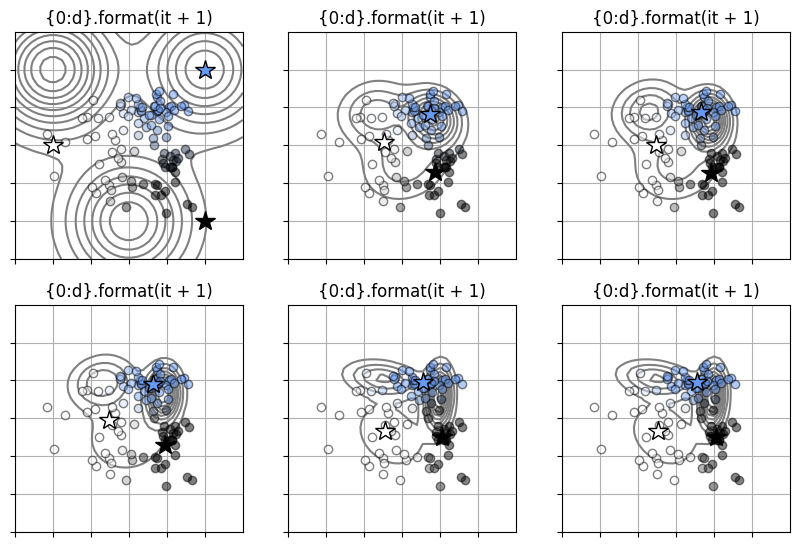

In [ ]:
# 다음으로 E step과 M step 반복
# 매개변수 초기값으로 돌린 후 20회를 반복해 도중의 경과를 표시

Pi = np.array([0.3, 0.3, 0.4])
Mu = np.array([[2,2], [-2,0], [2, -2]])
Sigma = np.array([[[1,0], [0,1]], [[1,0], [0,1]], [[1,0], [0,1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]
plt.figure(1, figsize=(10, 6.5))
max_it = 20

i_subplot = 1;
for it in range(0, max_it):
  Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)
  if it<4 or it>17:
    plt.subplot(2, 3, i_subplot)
    show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
    plt.title("{0:d}.format(it + 1)")
    plt.xticks(range(X_range0[0], X_range0[1]), "")
    plt.yticks(range(X_range1[0], X_range1[1]), "")
    i_subplot = i_subplot + 1
  Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)
plt.show()

위의 그림에서 보면 3개의 가우스 함수는 각 클러스터의 중심으로 이동해 수렴하는 것을 볼수 있다.

각 데이터 점에서 각 클러스터에 부담률은 그라데이션으로 나타내고 있다.


9.3.7 가능도

클러스터링의 장점을 평가하기 위해 K-means기법의 경우에는 왜곡 척도를 사용했지만, 가우시안 혼합 모델의 경우는 가능도를 사용한다.

가능도란 입력 데이터 X는 가우스 혼합 모델에서 생성된 것으로 생각하여, X가 생성된 확률(가능도)이라고 하며, 가장 가능도가 높도록 매개 변수가 갱신되고 있다.

가능도는 모든 데이터 점 X가 모델에서 생성된 확률이므로 아래의 식에 할당된다.

$$ P(X|π, μ, ∑) = Π_{n=0}^{N-1}∑_{k=0}^{K-1}π_kN(x_n | μ_k, Σk)  $$

log를 씌웠을 경우는 아래와 같다.

$$ logP(X|π, μ, ∑) = \sum_{n=0}^{N-1}{log∑_{k=0}^{K-1}π_kN(x_n | μ_k, Σk)}  $$

가능도나 로그 가능도를 최적화시킬 때는 극대화하기 때문에 -1을 곱한 음의 로그 가능도를 오차함수 E로 정의한다.

$$ E(π, μ, ∑)= -logP(X|π, μ, ∑) = -\sum_{n=0}^{N-1}{log∑_{k=0}^{K-1}π_kN(x_n | μ_k, Σk)}  $$

[426.22 229.86 224.32 220.8  218.63 216.93 215.93 215.51 215.33 215.24
 215.18 215.15 215.13 215.11 215.1  215.1  215.09 215.09 215.08 215.08]


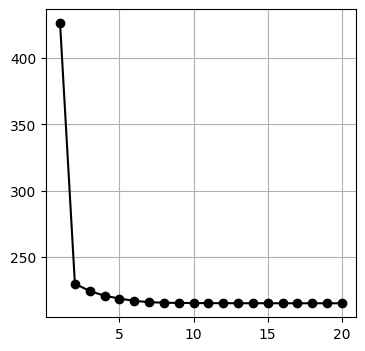

In [ ]:
# 오차함수 E를 확인해보기

# 혼합 가우스의 목적 함수
def nlh_mixgauss(x, pi, mu, sigma):
  N, D = x.shape
  K = len(pi)
  y = np.zeros((N,K))
  for k in range(K):
    y[:, k] = gauss(x, mu[k,:], sigma[k, :, :])
  lh = 0
  for n in range(N):
    wk = 0
    for k in range(K):
      wk = wk + pi[k] * y[n, k]
    lh = lh + np.log(wk)
  return -lh


Pi = np.array([0.3, 0.3, 0.4])
Mu = np.array([[2,2], [-2,0], [2, -2]])
Sigma = np.array([[[1,0], [0,1]], [[1,0], [0,1]], [[1,0], [0,1]]])
Gamma = np.c_[np.ones((N,1)), np.zeros((N, 2))]

max_it = 20
it = 0
Err = np.zeros(max_it)
for it in range(0, max_it):
  Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)
  Err[it] = nlh_mixgauss(X, Pi, Mu, Sigma)
  Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)

print(np.round(Err, 2))
plt.figure(2, figsize=(4,4))
plt.plot(np.arange(max_it)+ 1, Err, color= 'k', linestyle='-', marker='o')

plt.grid(True)
plt.show()

음의 로그 가능도는 점차 감소하여 10정도에서 수렴하는것을 볼 수 있다.